<a href="https://colab.research.google.com/github/linhhvo/emotion-classifier/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adadelta, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory 
from tensorflow.keras.applications import VGG16, VGG19, vgg16
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
import sys
import os
import random

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!unzip drive/MyDrive/images.zip > /dev/null

In [ ]:
labels = os.listdir('train')
labels

['surprise', 'disgust', 'happy', 'angry', 'fear', 'neutral', 'sad']

In [ ]:
np.random.seed(212)
tf.random.set_seed(101)

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '') # for validation results
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input) \
    .flow_from_directory(directory='train', target_size=(224,224), classes=labels)
validate_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input) \
    .flow_from_directory(directory='validation', target_size=(224,224), classes=labels, shuffle=False)

Found 20725 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


## Base Model

Include and freeze all VGG16 layers

In [ ]:
vgg16 = VGG16()

for layer in vgg16.layers:
  layer.trainable = False

vgg16.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
model = Sequential()

for layer in vgg16.layers[:-1]:
  model.add(layer)

model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
model.compile(
    optimizer='nadam',
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
earlystopper = EarlyStopping(
    patience=25,
    restore_best_weights=True,
    verbose=1)

history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validate_batches,
    validation_steps=len(validate_batches),
    epochs=40,
    callbacks=[earlystopper]
)

Epoch 1/40
648/648 [==============================] - 136s 151ms/step - loss: 1.7343 - accuracy: 0.3536 - val_loss: 1.9445 - val_accuracy: 0.3040
Epoch 2/40
648/648 [==============================] - 92s 142ms/step - loss: 1.4434 - accuracy: 0.4540 - val_loss: 1.8289 - val_accuracy: 0.3695
Epoch 3/40
648/648 [==============================] - 92s 142ms/step - loss: 1.3291 - accuracy: 0.5042 - val_loss: 1.8774 - val_accuracy: 0.3425
Epoch 4/40
648/648 [==============================] - 92s 142ms/step - loss: 1.2569 - accuracy: 0.5243 - val_loss: 1.7705 - val_accuracy: 0.3940
Epoch 5/40
648/648 [==============================] - 92s 142ms/step - loss: 1.2189 - accuracy: 0.5409 - val_loss: 1.8242 - val_accuracy: 0.3850
Epoch 6/40
648/648 [==============================] - 92s 142ms/step - loss: 1.1670 - accuracy: 0.5557 - val_loss: 1.7794 - val_accuracy: 0.3700
Epoch 7/40
648/648 [==============================] - 92s 142ms/step - loss: 1.1309 - accuracy: 0.5675 - val_loss: 1.7992 - val_a

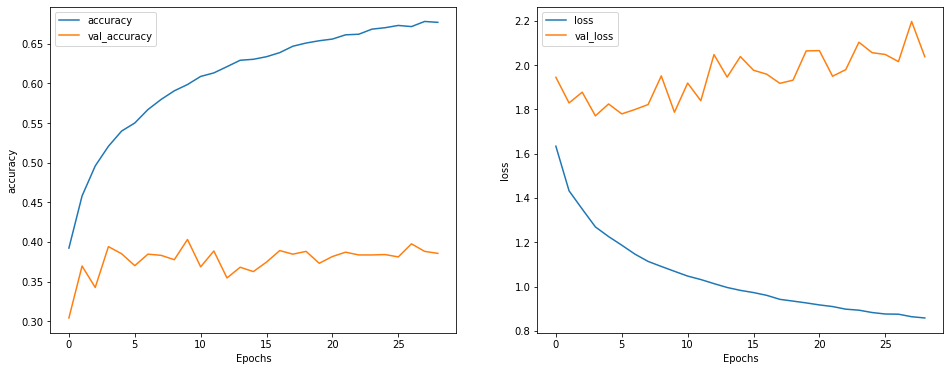

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [ ]:
train_loss, train_acc = model.evaluate(train_batches)
print('Train Accuracy: {:.2f}'.format(train_acc))

valid_loss, valid_acc = model.evaluate(validate_batches)
print('Validation Accuracy: {:.2f}'.format(valid_acc))


648/648 [==============================] - 83s 129ms/step - loss: 1.1290 - accuracy: 0.5804
Train Accuracy: 0.58
63/63 [==============================] - 8s 128ms/step - loss: 1.7705 - accuracy: 0.3940
Validation Accuracy: 0.39


## Model 1

Use custom fully-connected layers
Use lower learning rate

In [ ]:
vgg16 = VGG16(pooling='max', include_top=False)

for layer in vgg16.layers:
  layer.trainable = False

vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
model = Sequential()

for layer in vgg16.layers:
  model.add(layer)

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))

model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, None, None, 256)  

In [ ]:
model.compile(
    optimizer=Nadam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validate_batches,
    validation_steps=len(validate_batches),
    epochs=40
)

Epoch 1/40
648/648 [==============================] - 92s 141ms/step - loss: 2.5934 - accuracy: 0.2997 - val_loss: 1.9308 - val_accuracy: 0.2930
Epoch 2/40
648/648 [==============================] - 91s 141ms/step - loss: 1.4319 - accuracy: 0.4552 - val_loss: 1.7959 - val_accuracy: 0.3340
Epoch 3/40
648/648 [==============================] - 91s 141ms/step - loss: 1.2072 - accuracy: 0.5493 - val_loss: 1.8233 - val_accuracy: 0.3595
Epoch 4/40
648/648 [==============================] - 91s 141ms/step - loss: 1.0157 - accuracy: 0.6291 - val_loss: 1.9382 - val_accuracy: 0.3715
Epoch 5/40
648/648 [==============================] - 91s 141ms/step - loss: 0.7712 - accuracy: 0.7373 - val_loss: 1.9650 - val_accuracy: 0.3675
Epoch 6/40
648/648 [==============================] - 91s 141ms/step - loss: 0.5022 - accuracy: 0.8488 - val_loss: 2.0973 - val_accuracy: 0.3735
Epoch 7/40
648/648 [==============================] - 91s 141ms/step - loss: 0.2930 - accuracy: 0.9290 - val_loss: 2.3065 - val_ac

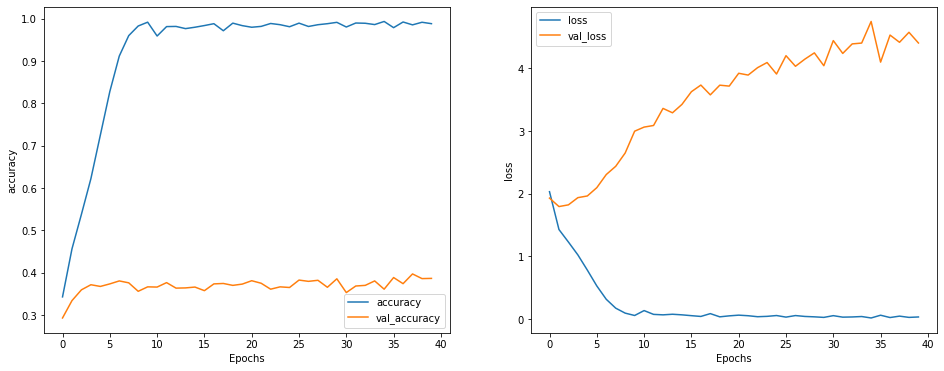

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [ ]:
train_loss, train_acc = model.evaluate(train_batches)
print('Train Accuracy: {:.2f}'.format(train_acc))

valid_loss, valid_acc = model.evaluate(validate_batches)
print('Validation Accuracy: {:.2f}'.format(valid_acc))

648/648 [==============================] - 82s 126ms/step - loss: 0.0163 - accuracy: 0.9945
Train Accuracy: 0.99
63/63 [==============================] - 8s 126ms/step - loss: 4.4038 - accuracy: 0.3865
Validation Accuracy: 0.39


## Model 2

Add dropout

Use early stopper and learning rate reducer

In [ ]:
vgg16 = VGG16(pooling='avg', include_top=False)

for layer in vgg16.layers[:-5]:
  layer.trainable = False

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
model = Sequential()

for layer in vgg16.layers:
  model.add(layer)

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, None, None, 256)  

In [ ]:
model.compile(
    optimizer=Nadam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
earlystopper = EarlyStopping(
    patience=25,
    restore_best_weights=True,
    verbose=1)

reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), patience=4, verbose=1)

history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validate_batches,
    validation_steps=len(validate_batches),
    epochs=40,
    callbacks=[earlystopper, reducer]
)

Epoch 1/40
648/648 [==============================] - 108s 165ms/step - loss: 2.1351 - accuracy: 0.1383 - val_loss: 1.9468 - val_accuracy: 0.1500
Epoch 2/40
648/648 [==============================] - 106s 164ms/step - loss: 1.9474 - accuracy: 0.1420 - val_loss: 1.9439 - val_accuracy: 0.1500
Epoch 3/40
648/648 [==============================] - 106s 164ms/step - loss: 1.9470 - accuracy: 0.1419 - val_loss: 1.9422 - val_accuracy: 0.1500
Epoch 4/40
648/648 [==============================] - 106s 164ms/step - loss: 1.9461 - accuracy: 0.1491 - val_loss: 1.9423 - val_accuracy: 0.1500
Epoch 5/40
648/648 [==============================] - 106s 164ms/step - loss: 1.9465 - accuracy: 0.1415 - val_loss: 1.9425 - val_accuracy: 0.1500
Epoch 6/40
648/648 [==============================] - 106s 164ms/step - loss: 1.9462 - accuracy: 0.1437 - val_loss: 1.9430 - val_accuracy: 0.1500
Epoch 7/40
648/648 [==============================] - 106s 164ms/step - loss: 1.9463 - accuracy: 0.1417 - val_loss: 1.9431 -

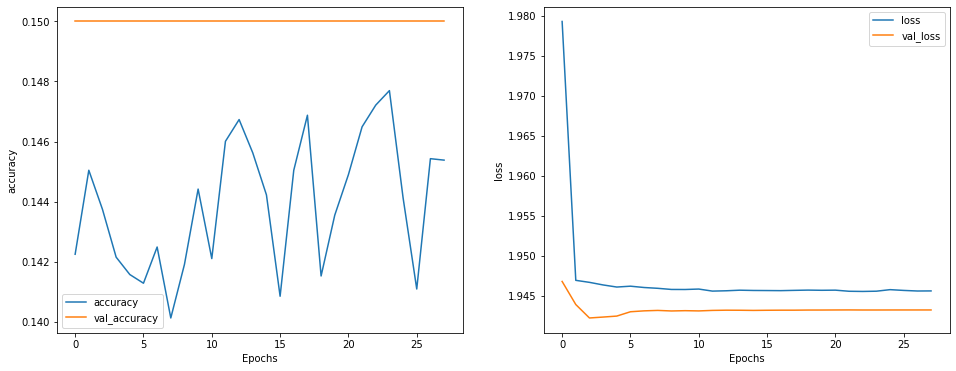

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [ ]:
train_loss, train_acc = model.evaluate(train_batches)
print('Train Accuracy: {:.2f}'.format(train_acc))

valid_loss, valid_acc = model.evaluate(validate_batches)
print('Validation Accuracy: {:.2f}'.format(valid_acc))

648/648 [==============================] - 82s 126ms/step - loss: 1.9458 - accuracy: 0.1448
Train Accuracy: 0.14
63/63 [==============================] - 8s 126ms/step - loss: 1.9422 - accuracy: 0.1500
Validation Accuracy: 0.15


## Model 3

Change data batch size

Change custom fully-connected layers

Add batch normalization

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(
        directory='train', 
        target_size=(224,224), 
        classes=labels, 
        batch_size=64)
    
validate_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(
        directory='validation', 
        target_size=(224,224), 
        classes=labels,
        batch_size=64)

Found 20725 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


In [ ]:
vgg16 = VGG16(pooling='max', include_top=False)

for layer in vgg16.layers[:-5]:
  layer.trainable = False

vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
model = Sequential()

for layer in vgg16.layers:
  model.add(layer)

model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu', kernel_initializer= 'he_uniform', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu', kernel_initializer= 'he_uniform', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax', name='predictions'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, None, None, 256)   2

In [ ]:
model.compile(
    optimizer=Nadam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
earlystopper = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    verbose=1)

reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), patience=4, verbose=1)

history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validate_batches,
    validation_steps=len(validate_batches),
    epochs=40,
    callbacks=[earlystopper, reducer]
)

Epoch 1/40
324/324 [==============================] - 157s 349ms/step - loss: 17.7923 - accuracy: 0.1865 - val_loss: 15.5478 - val_accuracy: 0.2440
Epoch 2/40
324/324 [==============================] - 100s 310ms/step - loss: 15.3930 - accuracy: 0.2890 - val_loss: 13.9215 - val_accuracy: 0.1910
Epoch 3/40
324/324 [==============================] - 100s 309ms/step - loss: 13.5306 - accuracy: 0.2976 - val_loss: 12.1905 - val_accuracy: 0.2515
Epoch 4/40
324/324 [==============================] - 100s 309ms/step - loss: 11.8077 - accuracy: 0.3216 - val_loss: 11.0617 - val_accuracy: 0.1540
Epoch 5/40
324/324 [==============================] - 100s 309ms/step - loss: 10.4682 - accuracy: 0.2954 - val_loss: 9.6288 - val_accuracy: 0.1950
Epoch 6/40
324/324 [==============================] - 100s 309ms/step - loss: 9.1323 - accuracy: 0.3044 - val_loss: 8.3096 - val_accuracy: 0.2770
Epoch 7/40
324/324 [==============================] - 100s 309ms/step - loss: 7.9446 - accuracy: 0.3223 - val_loss:

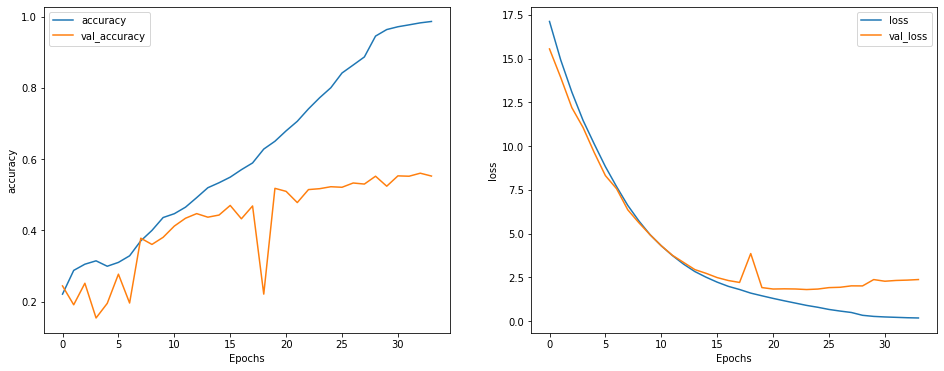

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [ ]:
train_loss, train_acc = model.evaluate(train_batches, verbose=1)
print('Train Accuracy: {:.2f}'.format(train_acc))

valid_loss, valid_acc = model.evaluate(validate_batches, verbose=1)
print('Validation Accuracy: {:.2f}'.format(valid_acc))

324/324 [==============================] - 79s 245ms/step - loss: 0.6967 - accuracy: 0.8450
Train Accuracy: 0.85
32/32 [==============================] - 8s 241ms/step - loss: 1.7999 - accuracy: 0.5170
Validation Accuracy: 0.52
